In [3]:
import utilities
from nsgt import CQ_NSGT
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

beatles = dataloader.Dataloader("beatles","/home/max/ET-TI/Masterarbeit/mirdata")
audiopath,annotations = beatles["1109"]

#audiopath = "/home/max/ET-TI/Masterarbeit/mirdata/beatles/audio/11_-_Abbey_Road/09_-_You_Never_Give_Me_Your_Money.wav"
# audiopath = "/home/max/ET-TI/Masterarbeit/mirdata/queen/audio/Greatest Hits I/07 Don't Stop Me Now.flac"
t,signal = utilities.loadAudio(audiopath,t_stop=20)
gt = utilities.loadAnnotations(annotations)
###################
# Tuning fehlt noch
###################

class interpolate:
    def __init__(self,cqt,Ls):
        self.intp = [interp1d(np.linspace(0, Ls, len(r)), r) for r in cqt]
    def __call__(self,x):
        try:
            len(x)
        except:
            return np.array([i(x) for i in self.intp])
        else:
            return np.array([[i(xi) for i in self.intp] for xi in x])

Ls = signal.data.shape[0]  # signal length
fmin = librosa.midi_to_hz(36)
fmax = librosa.midi_to_hz(108)
bins_per_octave = 12

detuning = librosa.estimate_tuning(y=signal,sr=22050)
fmin = fmin * 2**(detuning / bins_per_octave)
cq_nsgt = CQ_NSGT(fmin,fmax,bins=bins_per_octave,fs=22050,Ls=Ls)
cq_coeffs = np.array(cq_nsgt.forward(signal),dtype=object)
cq_coeffs = map(np.abs, cq_coeffs[2:-1])  # gleichanteil entfernt? 
# interpolate coefficients
hop_length = 1024   # ~0.9ms
x = np.linspace(0, Ls, Ls // hop_length)
cqt = interpolate(cq_coeffs,Ls)(x).T
t_cqt = np.linspace(0, Ls/22050, (Ls // hop_length))

# plot cqt
cqt_db = librosa.amplitude_to_db(cqt,ref=np.max)
fk = cq_nsgt.scale.F()
yticks = np.arange(0,len(fk),bins_per_octave,dtype=int)
yticklabels = np.round(cq_nsgt.scale.F()[yticks],0)
fig,ax = plt.subplots(figsize=(9,6))
img = librosa.display.specshow(cqt_db,x_coords=t_cqt,bins_per_octave=bins_per_octave,
                               fmin=fmin,fmax=fmax,x_axis="time", ax=ax,y_axis="cqt_note",cmap="viridis")
fig.colorbar(img,ax=ax)
ax.set_xlim(0,12)
plt.show()


pitchgram_cqt = np.finfo(float).eps * np.ones((108,cqt.shape[1]))
for note in range(36,108):
    pitchgram_cqt[note,:] = cqt[(note-36)*bins_per_octave//12,:]

v = pitchgram_cqt
v = v.reshape(9,12,-1)

chroma_cqt = np.sum(v, axis=0)
chroma_cqt = chroma_cqt / np.sum(np.abs(chroma_cqt)+np.finfo(float).eps,axis=0)


fig,(ax0,ax1)= plt.subplots(2,1,height_ratios=(1,10),figsize=(9,3))
utilities.plotChordAnnotations(ax0,gt,(0,10))
utilities.plotChromagram(ax1,t_cqt,chroma_cqt,chroma_type="cqt")


AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

(219, 21003)


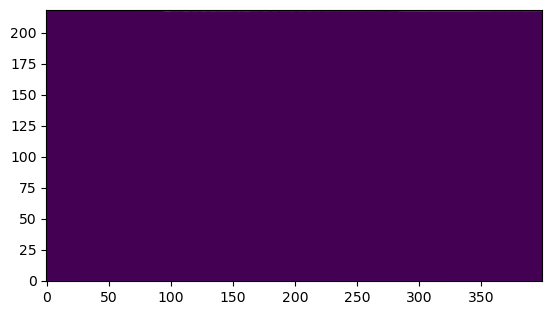

In [8]:
import dataloader
import features
import utilities
import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt
import pitchspace

PitchClass = namedtuple('PitchClass','name pitch_class_index chromatic_index num_accidentals')
""" 
    pitch_class_index : index of pitch class in chroma vector and list of pitch_classes
    chromatic_index : index n_c for pitch class in pitch space 
    num_accidentals : The number of accidentals n_k present in the key of this pitch class 
"""

pitch_classes = [
            PitchClass("C",0,-2,0),
            PitchClass("Db",1,-1,-5), # use enharmonic note with lowest accidentals (Db)! (C# has 7 crosses) 
            PitchClass('D',2,0,2),
            PitchClass("Eb",3,1,-3), 
            PitchClass("E",4,2,4),
            PitchClass("F",5,3,-1),
            PitchClass("F#",6,4,6),
            PitchClass("G",7,5,1),
            PitchClass("Ab",8,-6,-4), # Ab
            PitchClass("A",9,-5,3),
            PitchClass("Bb",10,-4,-2), #Bb
            PitchClass("B",11,-3,5)
]
"""A sorted list of Pitch classes: [C, C#/Db, .. , A#, B]"""

enharmonic_notes = {"C#":"Db","Db":"C#","D#":"Eb","Eb":"D#","F#":"Gb","Gb":"F#","G#":"Ab","Ab":"G#","A#":"Bb","Bb":"A#","B#":"C","C":"B#"}

beatles = dataloader.Dataloader("beatles","/home/max/ET-TI/Masterarbeit/mirdata")
audiopath,annotations = beatles["1206"]
gt = utilities.loadAnnotations(annotationpath=annotations)
t,signal = utilities.loadAudio(audiopath,t_stop=10)
t_chroma,chroma = features.crpChroma(signal,liftering=True,nCRP=33,norm=None,window=True)
# clip negative values and normalize with l1 norm
chroma = np.clip(chroma,0,None) 
chroma = chroma / np.sum(np.abs(chroma)+np.finfo(float).eps,axis=0)

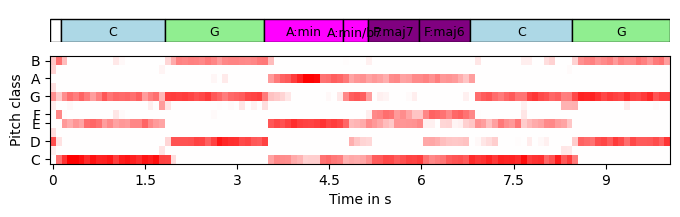

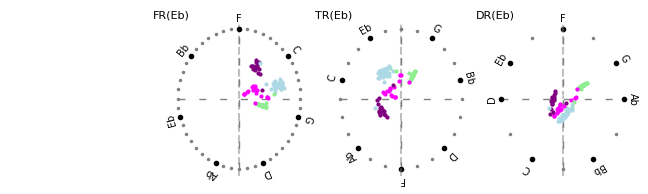

In [12]:
def sym(n,g):
    '''SYM-operator described by Gatzsche and Mahnert'''
    try:   
        return int(np.mod((n+(g/2)),g)-(g/2))
    except ValueError:
        return None 
    
def sym3(n,g,n0):
    '''three parameter SYM-operator described by Gatzsche and Mahnert'''
    x = sym(n-n0,g)
    if x is not None:
        return x+n0
    else:
        return None

def computeCPSSfeatures(chroma):
    """compute circular pitch space system features
        returns a 37xN array""" 
    if chroma.ndim == 1:
        chroma = np.reshape(chroma, (1, 12))
    elif chroma.shape[0] != 12:
        raise ValueError("Array shape must be (12, X).")

    rho_F  = np.zeros((chroma.shape[1],),dtype=complex)
    rho_FR = np.zeros_like(chroma,dtype=complex)
    rho_TR = np.zeros_like(chroma,dtype=complex)
    rho_DR = np.zeros_like(chroma,dtype=complex)

    for key in pitch_classes:  # iterate over pitch classes for key related circles
        n_k = key.num_accidentals
        key_index = key.pitch_class_index
        for pitch in pitch_classes: # iterate over all chroma bins
            n_f = sym3(49*pitch.chromatic_index,84,7*n_k) # index in sequence of perfect fifths
            if n_k == 0:
                rho_F += chroma[pitch.pitch_class_index,:] * np.exp(-1j*2*np.pi*(n_f/84)) * 1j
            if -21 <= (n_f-7*n_k) < 21:
                n_fr = sym(n_f-7*n_k, 48) # index in key related circle of fifths
                rho_FR[key_index,:] += chroma[pitch.pitch_class_index,:] * np.exp(-1j*2*np.pi*(n_fr/48)) * 1j
                
                # third related circle  
                n_tr = sym(n_f-7*n_k-12,24)  # index in key related circle of thirds
                rho_TR[key_index,:] += chroma[pitch.pitch_class_index,:] * np.exp(-1j*2*np.pi*(n_tr/24)) * 1j     
                # diatonic circle   
                n_dr = sym(n_f-7*n_k,12)  # index in key related diatonic circle
                rho_DR[key_index,:] += chroma[pitch.pitch_class_index,:] * np.exp(-1j*2*np.pi*(n_dr/12)) * 1j

    F = np.zeros((2,chroma.shape[1]),dtype=float)
    FR = np.zeros((24,chroma.shape[1]),dtype=float)
    TR = np.zeros((24,chroma.shape[1]),dtype=float)
    DR = np.zeros((24,chroma.shape[1]),dtype=float)
    F[0,:] = rho_F.real
    F[1,:] = rho_F.imag
    for i,key_index in zip(np.arange(0,24,2),range(12)):
        FR[i  ,:] = rho_FR[key_index,:].real
        FR[i+1,:] = rho_FR[key_index,:].imag
    for i,key_index in zip(np.arange(0,24,2),range(12)):
        TR[i  ,:] = rho_TR[key_index,:].real
        TR[i+1,:] = rho_TR[key_index,:].imag
    for i,key_index in zip(np.arange(0,24,2),range(12)):
        DR[i  ,:] = rho_DR[key_index,:].real
        DR[i+1,:] = rho_DR[key_index,:].imag
    return F,FR,TR,DR
import librosa.display
F,FR,TR,DR = computeCPSSfeatures(chroma)
features = np.concatenate((F,FR,TR,DR),axis=0)



# Representation in the circle space
fig,ax = plt.subplots(2,height_ratios=(3,10),figsize=(8,2))
utilities.plotChordAnnotations(ax[0],gt,(0,10))
utilities.plotChromagram(ax[1],t_chroma,chroma)
fig,axes = plt.subplots(1,4,figsize=(8,2))
# utilities.plotCircleF(axes[0])
utilities.plotCircleFR(axes[1],3)
utilities.plotCircleTR(axes[2],3,alterations=False)
utilities.plotCircleDR(axes[3],3)

axes[0].set_axis_off()
# extract colors from ground truth chordlabels
chord_labels = []
# for i in range(chroma.shape[1]):
hopsize = t_chroma[1]-t_chroma[0]
for intervals,label in zip(gt[0],gt[1]):
    try:
        t_start = np.argwhere(t_chroma >= intervals[0])[0]
        t_stop = np.argwhere(t_chroma >= intervals[1])[0]
    except IndexError:
        t_stop = chroma.shape[1]
    chord_labels.extend([label] * int(t_stop-t_start))


for i in range(chroma.shape[1]):
    color = utilities.getColor(chord_labels[i])
    #axes[0].plot(F[0,i],F[1,i],'o',markersize=2,color=color)
    axes[1].plot(FR[6,i],FR[7,i],'o',markersize=2,color=color)
    axes[2].plot(TR[6,i],TR[7,i],'o',markersize=2,color=color)
    axes[3].plot(DR[6,i],DR[7,i],'o',markersize=2,color=color)


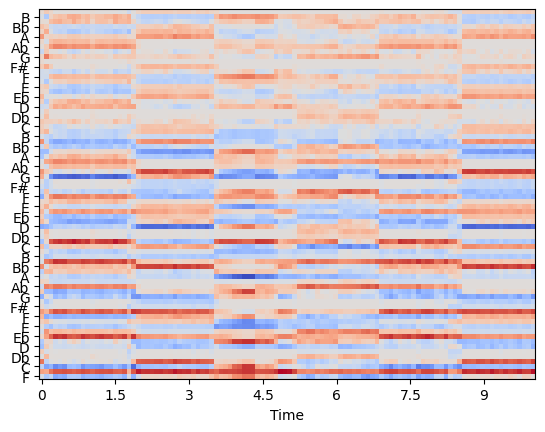

In [3]:
fig,ax = plt.subplots()
# create xlabel
ylabels = ["F"]
for pc in pitch_classes:
    ylabels.append(pc.name)
for pc in pitch_classes:
    ylabels.append(pc.name)
for pc in pitch_classes:
    ylabels.append(pc.name)
       
img = librosa.display.specshow(features,ax=ax,x_coords=t_chroma,x_axis="time")
ax.set_yticks(np.arange(0,2*len(ylabels),2))
ax.set_yticklabels(ylabels);

frames per beat: 4.0


(0.0, 10.0)

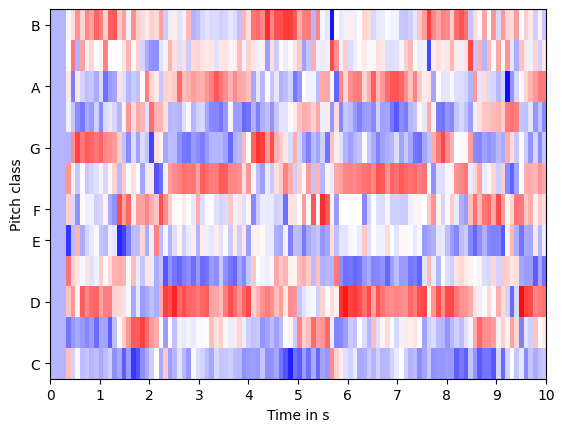

In [4]:
import numpy as np
import utilities
import features
import matplotlib.pyplot as plt
path = "/home/max/ET-TI/Masterarbeit/mirdata/beatles/audio/01_-_Please_Please_Me/09_-_P._S._I_Love_You.wav"
t,sig = utilities.loadAudio(path,t_stop=30)
t_chroma,chroma = features.crpChroma(sig)
beats,tempo_bpm = features.beats(sig)
fpb = 60 // ((t_chroma[1]-t_chroma[0])*tempo_bpm)
print(f"frames per beat: {fpb}")
 
fig,ax = plt.subplots()
utilities.plotChromagram(ax,t_chroma,chroma)
ax.set_xlim(0,10)

Recurrency plots


$C(c,n) = \sum_{m=0}^{M-1} \frac{\sum_{i=1}^{\hat{N}}W_{i,n-m}\: C(c,i)}{\sum_{i=1}^{\hat{N}}W_{i,n-m}} \hspace{1cm} \hat{N} = N-M+1$

In [ ]:
# load dataset
import dataloader
import utilities
import transcribe
import matplotlib.pyplot as plt
import numpy as np
import madmom
import os
from datetime import datetime
import features
import pickle

parameters = {"chroma_type":"crp",
        "vocabulary":"majmin_sevenths",  # triads, triads_extended, majmin_sevenths
        "eval_scheme":"majmin_sevenths",
        "hprs":False,
        "prefilter":"median",
        "prefilter_length":17,
        "postfilter":"hmm",
        "transition_prob":0.2,
        "save_transcription":False
}

PATH = "/home/max/ET-TI/Masterarbeit/mirdata/"
output_path = "/home/max/ET-TI/Masterarbeit/results/"
timestamp = datetime.now().strftime('%m_%d_%Y_%H_%M_%S')
output_path += timestamp
os.mkdir(output_path)
if parameters.get('save_transcription',False):
    os.mkdir(output_path+"/chromagrams")
    os.mkdir(output_path+"/transcriptions")
results= {}
results["parameters"] = parameters
for fold in range(1,9):
    for name in ["rwc_popular","beatles"]:
        dataset = dataloader.MIRDataset(name,basepath=PATH,split_nr=fold)
        for track_id in dataset.getTrackList():
            try:
                name = dataset.getTitle(track_id).split("_-_")[-1]
                track_results = {}
            except KeyError:
                print(f"error loading {name}.. skipping song")
                continue
            audiopath,(ref_intervals,ref_labels) = dataset[track_id]

            time_vector,signal = utilities.loadAudio(audiopath)

            ## HPS ##
            if parameters.get("hprs",False):
                y_harm,y_perc,y_res = transcribe.harmonicPercussiveResidualSeparation(signal,beta=3,n_fft=4096)
                signal = madmom.audio.signal.Signal(y_harm, sample_rate=signal.sample_rate, num_channels=1, start=signal.start, stop=signal.stop)

            if parameters.get("chroma_type","crp") == "crp":
                t_chroma,chroma = features.crpChroma(signal)
            elif parameters.get("chroma_type") == "dcp":
                t_chroma,chroma = features.deepChroma(signal,split_nr=fold)
            else:
                t_chroma,chroma = features.cqtChroma(signal)

            est_intervals, est_labels = transcribe.transcribeChromagram(t_chroma,chroma,**parameters)
            score,mean_seg_score = transcribe.evaluateTranscription(est_intervals,est_labels,ref_intervals,ref_labels,parameters.get("eval_scheme","majmin"))
            print(f"Track: {name}, {parameters.get('eval_scheme','majmin')}: {round(score*100,1)}, segmentation: {round(mean_seg_score*100,1)}")
            track_results[parameters.get('eval_scheme','majmin')] = score
            track_results["segmentation"] = mean_seg_score
            if parameters.get('save_transcription',False):
                track_results["t_chroma"] = t_chroma
                track_results["chroma"] = chroma
                track_results["est_intervals"] = est_intervals
                track_results["est_labels"] = est_labels
                utilities.saveTranscriptionResults(output_path,name,t_chroma,chroma,est_intervals,est_labels,ref_intervals,ref_labels)

            results[name] = track_results 
            break
        continue
f = open(output_path+f"/{parameters.get('eval_scheme','majmin')}_{parameters.get('chroma_type')}.pkl","wb")
pickle.dump(results, f)
f.close()


Track: Magic in your eyes, majmin_sevenths: 6.0, segmentation: 32.0
Track: Do_You_Want_To_Know_A_Secret, majmin_sevenths: 37.0, segmentation: 68.0
Track: Catch ball, majmin_sevenths: 54.0, segmentation: 85.0
Track: Misery, majmin_sevenths: 65.0, segmentation: 84.0
Track: HORO, majmin_sevenths: 49.0, segmentation: 76.0
Track: I_Saw_Her_Standing_There, majmin_sevenths: 75.0, segmentation: 79.0
Track: old fashioned, majmin_sevenths: 57.0, segmentation: 81.0
Track: Anna_(Go_To_Him), majmin_sevenths: 9.0, segmentation: 67.0
Track: KAGE-ROU, majmin_sevenths: 58.0, segmentation: 83.0
Track: There's_A_Place, majmin_sevenths: 79.0, segmentation: 87.0
Track: Eien no replica, majmin_sevenths: 39.0, segmentation: 80.0
Track: Love_Me_Do, majmin_sevenths: 53.0, segmentation: 25.0
Track: Funky Life, majmin_sevenths: 8.0, segmentation: 68.0
Track: Ask_Me_Why, majmin_sevenths: 42.0, segmentation: 75.0
Track: Doukoku, majmin_sevenths: 68.0, segmentation: 82.0
Track: Boys, majmin_sevenths: 20.0, segmenta

Zeitrasterung/processingrate der Features
-> fein abgetastete Beatactivations als feature für die zeitliche Akkordanalyse verwenden
gewichtung anhand von beataktivierung

(0.0, 10.0)

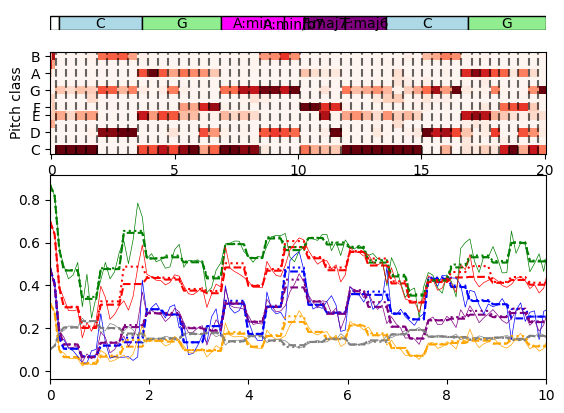

In [ ]:

beats = features.beats(sig)
t,chroma = features.crpChroma(sig,nCRP=22,filter_scale=1)

chroma_smoothed = utilities.smoothChromagram(t,chroma,beats)
target = mir_eval.io.load_labeled_intervals(path+"/annotations/chordlab/The Beatles/"+title+".lab",' ','#')

f0, voiced_flag, voiced_probs = librosa.pyin(np.array(sig.data),
                                             fmin=librosa.note_to_hz('C2'),
                                             fmax=librosa.note_to_hz('C4'))
librosa.hz_to_note(440.0 * (2.0 ** np.linspace(0, 1, 12)),
                   octave=False)
bass_chroma = np.zeros((f0.shape[0],12))
for i,freq in enumerate(f0):
    try:
        x = librosa.hz_to_note(freq,octave=False,unicode=False)
        root,_,_ = mir_eval.chord.encode(x)
        bass_chroma[i,root] = 1
    except ValueError:
        continue
        
# COMPLEXITY
colors = ["blue", "green", "red", "orange", "purple", "grey"]
complexity_features = [
                features.sumChromaDifferences(chroma),
                features.angularDeviation(chroma),
                features.shannonEntropy(chroma),
                features.negativeSlope(chroma),
                features.nonSparseness(chroma),
                features.standardDeviation(chroma)
]
complexity_features_smooth = [
                features.sumChromaDifferences(chroma_smoothed),
                features.angularDeviation(chroma_smoothed),
                features.shannonEntropy(chroma_smoothed),
                features.negativeSlope(chroma_smoothed),
                features.nonSparseness(chroma_smoothed),
                features.standardDeviation(chroma_smoothed)
]

fig,ax = plt.subplots(3,1,height_ratios=(1,5,10))
utilities.plotChordAnnotations(ax[0],target,(t_start,t_stop))
utilities.plotChromagram(ax[1],t,chroma_smoothed,beats)
for i,x in enumerate(complexity_features):    
    complexity_mean = np.copy(x)
    for b0,b1 in itertools.pairwise(beats):
        # median filter
        try:
            idx0 = np.argwhere(t >= b0)[0][0]
        except IndexError:
            # no matching interval found at array boundaries
            idx1 = 0
        try:
            idx1 = np.argwhere(t >= b1)[0][0]
        except IndexError:
            idx1 = t.shape[0] 
        if idx1-idx0 > 0: 
            complexity_mean[idx0:idx1] = np.mean(x[idx0:idx1])
    ax[2].plot(t,complexity_mean,color=colors[i],linestyle='--')

for i,x in enumerate(complexity_features):    
    ax[2].plot(t,x,color=colors[i],linewidth=0.5)
for i,x in enumerate(complexity_features_smooth):
    ax[2].plot(t,x,color=colors[i],linestyle=':')
ax[2].set_xlim([t_start,t_stop])
